In [7]:
import sys
sys.path.append('/home/jovyan/work/d2l/notebooks/d2l_utils')
import d2l
import torch
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


class HighDimData(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        self.w, self.b = torch.ones(num_inputs, 1) * 0.01, 0.05
        self.y = torch.matmul(self.X, self.w) + self.b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)


class WeightDecayScratch(d2l.LinearRegressScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * d2l.l2_penalty(self.w)
    

class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()

    def configure_optimizers(self):
        return torch.optim.SGD([{'params': self.net.weight, 'weight_decay': self.wd},
                                {'params': self.net.bias}], lr=self.lr)


def train_strach(lambd, trainer, data):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    train_loss, valid_loss = trainer.fit(model, data)
    if trainer.plot_flag:
        print(f'l2 norm of w:{d2l.l2_penalty(model.w):.2g}')
    return train_loss, valid_loss

l2 norm of w:0.012


(4.6591752834501676e-05, 0.4330679289996624)

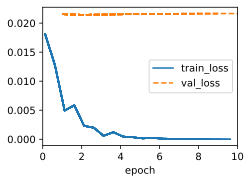

In [3]:
data = HighDimData(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)
train_strach(0, trainer, data)

l2 norm of w:0.0013


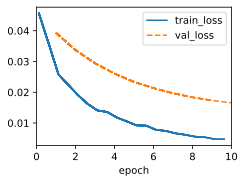

In [3]:
trainer = d2l.Trainer(max_epochs=10)
train_strach(3, trainer, data)

l2 norm of w: 0.0136


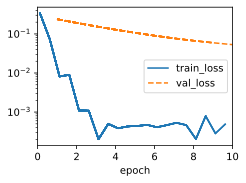

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale = 'log'
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print(f'l2 norm of w: {d2l.l2_penalty(model.net.weight):.4g}')

# 3.7.6. Exercises

## 1. Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?

**Training Curve**: Initially, as λ increases, the training accuracy (or reduction in MSE) might decrease. This is because the model is being regularized more heavily, leading to a simpler model that may not fit the training data as closely. Very high λ values can cause underfitting, leading to poor training accuracy.

**Validation Curve**: Validation accuracy might initially improve as λ increases, as the model becomes less prone to overfitting. However, beyond a certain point, increasing λ further can cause the validation accuracy to start decreasing. This is because very high λ values can cause the model to underfit the data and perform poorly on both training and validation sets.

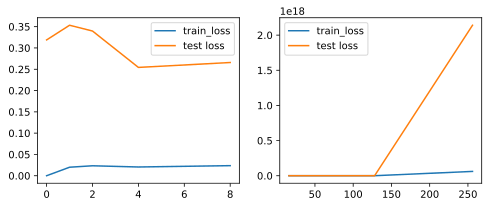

In [17]:
data = HighDimData(num_train=20, num_val=100, num_inputs=200, batch_size=5)
lambds = d2l.gen_logrithm_nums(initial_value = 1,growth_factor = 2,num_elements = 10)
lambds.insert(0, 0)
train_loss, test_loss = [],[]
for lambd in lambds:
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    temp = train_strach(lambd, trainer, data)
    train_loss.append(temp[0])
    test_loss.append(temp[1])
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(lambds[:5], train_loss[:5], label='train_loss')
plt.plot(lambds[:5], test_loss[:5], label='test loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(lambds[5:], train_loss[5:], label='train_loss')
plt.plot(lambds[5:], test_loss[5:], label='test loss')
plt.legend()
plt.show()

## 2. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?

The value of $\lambda$ that provides the best performance on the validation set can be considered an optimal choice within the given dataset, it might not necessarily be the universally optimal value for all datasets or real-world scenarios. This is because the optimal value of $\lambda$ can be influenced by the specific characteristics of the dataset we're working with.
Here's why this matters:

1. **Dataset Variability**: Different datasets might have different levels of noise, feature scales, and complexities. Therefore, the optimal value of $\lambda$ can vary across datasets. What works well for one dataset might not work as well for another.

2. **Generalization**: The goal of finding an optimal value of $\lambda$ is to achieve a model that generalizes well to unseen data. While the chosen $\lambda$ might work well on the validation set, it's important to also evaluate its performance on a separate test set or in real-world scenarios to ensure that the regularization choice results in good generalization.

3. **Overfitting and Underfitting**: Depending on the dataset and the model's complexity, you might observe different behaviors with different $\lambda$ values. A smaller $\lambda$ might lead to overfitting, while a larger $\lambda$ might lead to underfitting. The optimal balance between regularization and fitting the data well can vary.

4. **Hyperparameter Tuning**: Hyperparameters like $\lambda$ should ideally be tuned using techniques like cross-validation to mitigate the impact of dataset-specific variations. Cross-validation involves partitioning the data multiple times into training, validation, and test sets, allowing you to better estimate the performance of different hyperparameter choices on unseen data.

5. **Robustness**: It's a good practice to explore a range of $\lambda$ values rather than just relying on the single optimal value found on the validation set. This helps you understand the sensitivity of the model to different levels of regularization and allows you to choose a value that provides a good balance across different scenarios.

In summary, while finding the optimal value of $\lambda$ on a validation set is a useful technique for selecting an appropriate regularization strength, it's crucial to remember that it might not be universally optimal. Regularization plays a significant role in preventing overfitting and improving model generalization, but it's essential to verify the chosen regularization parameter on independent test data and to understand its behavior across different contexts.

## 3. What would the update equations look like if instead of $\Vert{w}\Vert^{2}$ we used $\sum_{i}{|w_i|}$ as our penalty of choice ($l_1$regularization)?

$w_j = (1+\lambda \cdot \text{sgn}(w_j))w_j - \alpha \left( -\frac{1}{N} \sum_{i=1}^{N} (y_i - \mathbf{w}^T \mathbf{x}_i) x_{ij}\right)$

## 4. We know that $\Vert{w}\Vert^{2}=w^{T}w$. Can you find a similar equation for matrices (see the Frobenius norm in Section 2.3.11)?

The Frobenius norm of a matrix \(A\) is defined as the square root of the sum of the squared magnitudes of its individual elements. It is commonly denoted as \(\|A\|_F\). The Frobenius norm is analogous to the \(l_2\) norm for vectors. The Frobenius norm of a matrix \(A\) can be computed using the element-wise square root and sum of squares:

$\|A\|_F = \sqrt{\sum_{i=1}^{m}\sum_{j=1}^{n} |a_{ij}|^2}$

Where:
- \(m\) is the number of rows in the matrix \(A\).
- \(n\) is the number of columns in the matrix \(A\).
- \(a_{ij}\) is the element at the \(i\)-th row and \(j\)-th column of the matrix \(A\).

Analogous to the vector case, you can express the Frobenius norm of a matrix \(A\) in terms of its matrix-vector form as follows:

$\|A\|_F^2 = \text{Tr}(A^TA)$

Where:
- $\text{Tr}(A)$ denotes the trace of the matrix $A$, which is the sum of its diagonal elements.

## 5. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?



The relationship between training error and generalization error is a fundamental concept in machine learning. Training error is the error that a model makes on the data it was trained on, while generalization error is the error it makes on new, unseen data. The goal is to build a model that has a low generalization error, which indicates that it can perform well on data it has never encountered before.

Here's a review of the relationship between training and generalization error, along with additional techniques to deal with overfitting:

**Training Error vs. Generalization Error:**

- **Training Error**: Training error measures how well the model fits the training data. A model that perfectly fits the training data might suffer from overfitting, where it learns the noise in the data rather than the underlying patterns.

- **Generalization Error**: Generalization error measures how well the model performs on new, unseen data. A model with high generalization error might be underfitting, meaning it fails to capture the underlying patterns in the data.

**Ways to Deal with Overfitting:**

1. **Regularization Techniques**: Regularization methods like weight decay (L2 regularization) and L1 regularization can prevent overfitting by adding a penalty to the loss function, encouraging the model to have smaller weights or inducing sparsity in the weights.

2. **Cross-Validation**: Cross-validation helps estimate a model's generalization performance by splitting the data into training and validation sets. It provides a better sense of how well the model will perform on new data and helps in selecting hyperparameters.

3. **Early Stopping**: Monitor the validation error during training and stop training once the validation error starts increasing. This prevents the model from overfitting the training data as training progresses.

4. **Data Augmentation**: Increasing the size of the training dataset by applying transformations to the data (e.g., rotation, cropping, flipping) can help the model generalize better and reduce overfitting.

5. **Feature Engineering**: Selecting relevant features and reducing irrelevant ones can help the model focus on the most important patterns in the data, reducing overfitting.

6. **Ensemble Methods**: Combining the predictions of multiple models can improve generalization. Techniques like bagging, boosting, and random forests create diverse models that collectively perform better on new data.

7. **Dropout**: Dropout is a regularization technique used mainly in neural networks. It randomly deactivates a portion of the neurons during each training iteration, forcing the network to learn robust representations.

8. **Simpler Models**: Use models of suitable complexity. A model that is too complex can memorize the training data and overfit, while a model that is too simple might underfit.

9. **Hyperparameter Tuning**: Experiment with different hyperparameters and architectures to find the best combination that balances training and generalization.

10. **Domain Knowledge**: Incorporating domain-specific knowledge can guide the feature selection process and help avoid overfitting to noise.

## 6. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w|x) \propto P(x|w)P(w)$. How can you identify $P(w)$ with regularization?

In this context, the prior distribution $P(w)$ can act as a form of regularization. It influences the shape of the posterior distribution, encouraging certain values of the parameters $w$ over others based on our prior beliefs.

Regularization is particularly useful when dealing with ill-posed or ill-conditioned problems, or when there's limited data available. It helps prevent overfitting, which occurs when a model becomes too complex and fits noise in the data rather than the underlying patterns.

There are different forms of regularization that can be applied through the choice of the prior distribution $P(w)$. Some common types of priors used for regularization include:

1. **L2 (Ridge) Regularization**: In this case, the prior distribution $P(w)$ is chosen to be a Gaussian distribution with mean 0 and a fixed variance (scale parameter). This encourages the parameter values to be closer to zero, effectively penalizing large parameter values.

Using maximum likelihood estimation, we can demonstrate how the L2 (Ridge) penalty arises as an assumption of a Gaussian (normal) prior distribution. We start from the likelihood function, introduce the Gaussian prior, and show how it leads to the form of L2 regularization.

Consider a linear regression model:

$y = Xw + \epsilon$

Where:
- $y$ is the vector of observations.
- $X$ is the design matrix (feature matrix).
- $w$ is the parameter vector.
- $\epsilon$ is the error vector, assumed to follow a Gaussian distribution with mean zero and variance $\sigma^2$: $\epsilon \sim \mathcal{N}(0, \sigma^2I)$.

Our goal is to estimate the parameter vector \(w\) through maximum likelihood estimation. The likelihood function is:

$P(y|X, w, \sigma^2) = \frac{1}{(2\pi\sigma^2)^{n/2}} \exp\left(-\frac{1}{2\sigma^2}\|y - Xw\|^2\right)$

Where $n$ is the number of observations.

Now, let's introduce a prior distribution to regularize the parameters \(w\). Assume the prior distribution is Gaussian:

$P(w) = \frac{1}{(2\pi\tau^2)^{p/2}} \exp\left(-\frac{1}{2\tau^2}\|w\|^2\right)$

Where $p$ is the number of parameters and $\tau$ is the regularization parameter.

We want to maximize the product of the likelihood function and the prior distribution, which will lead to the posterior distribution. Consider the negative logarithm of the likelihood and the negative logarithm of the prior (usually, we minimize the negative log-likelihood for optimization purposes):

$-\log P(y|X, w, \sigma^2) = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\|y - Xw\|^2$

$-\log P(w) = \frac{p}{2}\log(2\pi\tau^2) + \frac{1}{2\tau^2}\|w\|^2$

Summing up the negative logarithms of the likelihood and the prior, we obtain:

$J(w) = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\|y - Xw\|^2 + \frac{p}{2}\log(2\pi\tau^2) + \frac{1}{2\tau^2}\|w\|^2$

Our objective is to minimize $J(w)$. By taking derivatives with respect to the parameter $w$ and setting them to zero, we can find the solution that minimizes $J(w)$. This solution incorporates the influence of the Gaussian prior and leads to the maximum likelihood estimate with L2 regularization, effectively achieving the desired L2 regularization effect.

2. **L1 (Lasso) Regularization**: The L1 regularizer introduces a Laplace distribution as the prior for the parameters, which leads to a sparsity-inducing effect. This can drive some parameter values to exactly zero, effectively performing feature selection.

3. **Elastic Net Regularization**: This combines both L2 and L1 regularization, balancing their effects to provide a compromise between their individual benefits.

4. **Hierarchical Priors**: Instead of using fixed values for the regularization parameters, you can introduce additional levels of uncertainty by using hierarchical priors. These allow the data to inform the scale of the regularization, which can be particularly useful when there's uncertainty about the amount of regularization needed.

5. **Nonparametric Priors**: In cases where you don't have strong prior beliefs about the parameters, nonparametric priors like Gaussian processes or Dirichlet processes can be used. These allow the data to drive the shape of the posterior distribution.

The choice of the prior distribution depends on the problem at hand, the available domain knowledge, and the level of regularization you want to apply. The goal is to strike a balance between fitting the data well and preventing overfitting by incorporating relevant information into the model.